# Empirical Risk Minimization (ERM)

Empirical Risk Minimization (ERM) is a Bayesian inference technique used to make "optimal" decisions about new data based on labelled data we have previously seen. This is explicitly achieved by selection decisions that result in the smallest expected risk.

Imports for this notebook:

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Gaussian Mixture Model Setting

Mixture models have the form:

$$ p(\mathbf{x}) = \sum_{k=1}^K a_k p_k(\mathbf{x}) $$

Such that they are a linear combination of multiple component distributions, where $p_k(\mathbf{x})$ is the $k^{th}$ probability density function (pdf), and $a_k$ is the $k^{th}$ "mixture weight", such that both $0 \leq a_k \leq 1$ and $\sum_{k=1}^K a_k = 1$ are satisfied.

Let's look at the concrete example of a Gaussian Mixture Model (GMM), such that $p_k(\mathbf{x}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu_k}, \mathbf{\Sigma_k})$ for $k \in \{1, ..., K\}$, with each $k^{th}$ component distribution represented as a multivariate Gaussian. Effectively, we are "choosing" a Gaussian pdf to sample from based on the weights $a_k$. Please refer to Chpt. 3.5 of Murphy's 2022 book for a more formal review.

Below provides an example of how to draw samples using the SciPy library, notably the `scipy.stats` module. It also defines the dataset setting for our ERM demonstration, which consists of the following class-conditionals:

$$ p(\mathbf{x} | y_0) = \mathcal{N}(\mathbf{x} | \mathbf{\mu_{0}}, \mathbf{\Sigma_{0}})$$
$$ p(\mathbf{x} | y_1) = \mathcal{N}(\mathbf{x} | \mathbf{\mu_{1}}, \mathbf{\Sigma_{1}})$$
$$ p(\mathbf{x} | y_2) = \mathcal{N}(\mathbf{x} | \mathbf{\mu_{2}}, \mathbf{\Sigma_{2}})$$

Where we have 3 multivariate Gaussian class-conditionals, each with their own respective mean vectors and covariance matrices. Assume our class priors are $P(Y=0)=0.2$, $P(Y=1)=0.5$ and $P(Y=2)=0.3$. Using a GMM, we will assume the following parameters for the class-conditionals:

\begin{equation*}
    \mathbf{\mu}_0=\begin{bmatrix} 1\\4 \end{bmatrix} ~~~
    \mathbf{\Sigma}_0=\begin{bmatrix}1 & -1.5 \\-1.5 & 3 \end{bmatrix}, ~~~
    \mathbf{\mu}_1=\begin{bmatrix} -10\\-2 \end{bmatrix} ~~~
    \mathbf{\Sigma}_1=\begin{bmatrix}2 & 1.5 \\1.5 & 8 \end{bmatrix}, ~~~
    \mathbf{\mu}_2=\begin{bmatrix} 3\\10 \end{bmatrix} ~~~
    \mathbf{\Sigma}_2=\begin{bmatrix}4 & 2.5 \\2.5 & 4 \end{bmatrix} \\
\end{equation*}

Illustrating that we have 2-dimensional bivariate Gaussian component distributions. Let's generate this data and color-code the individual components based on their labels:

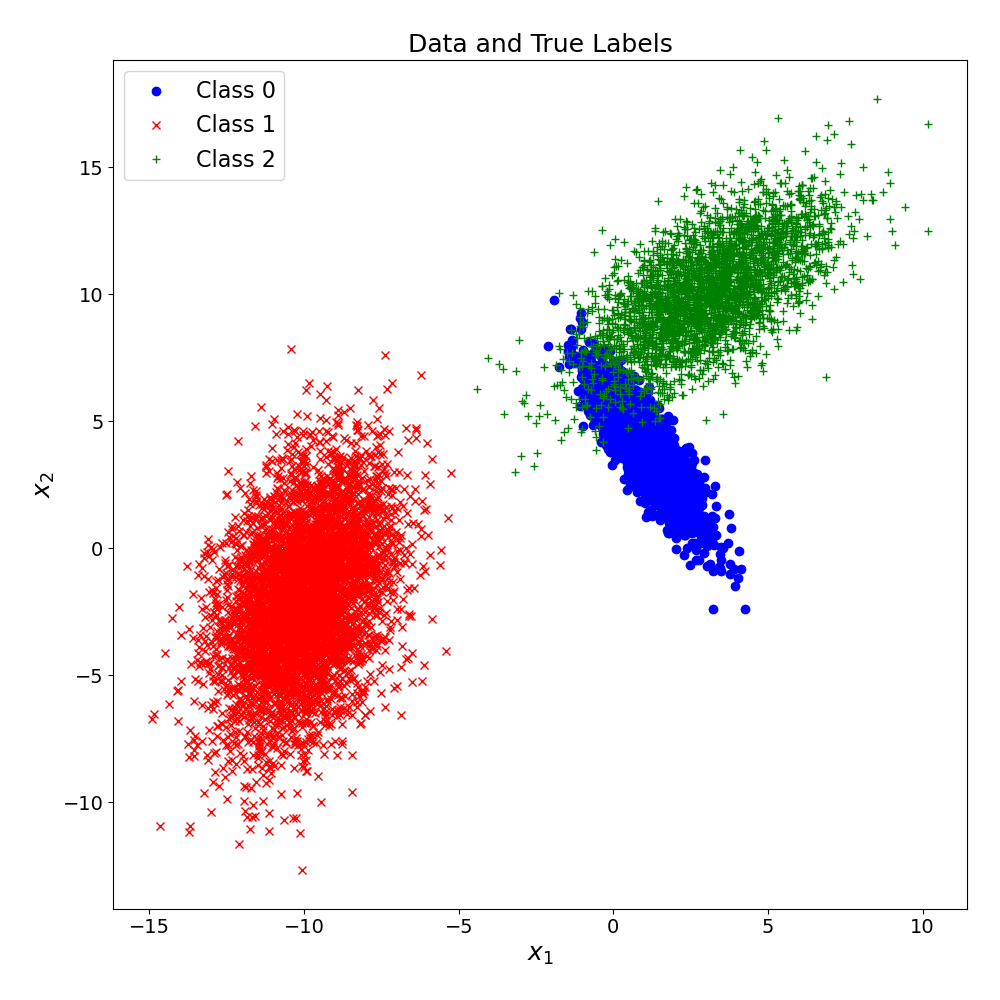

In [2]:
# Number of samples to draw from each distribution
N = 10000

# Likelihood of each distribution to be selected AND class priors!!!
priors = np.array([0.2, 0.5, 0.3])  
# Determine number of classes/mixture components
C = len(priors)
mu = np.array([[1, 4],
               [-10, -2],
               [3, 10]])  # Gaussian distributions means
Sigma = np.array([[[1, -1.5],
                   [-1.5, 3]],
                  [[2, 1.5],
                   [1.5, 8]],
                  [[4, 2.5],
                   [2.5, 4]]])  # Gaussian distributions covariance matrices

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]
# Output samples and labels
X = np.zeros([N, n])
y = np.zeros(N)

# Decide randomly which samples will come from each component
u = np.random.rand(N)
thresholds = np.cumsum(priors)

for c in range(C):
    c_ind = np.argwhere(u <= thresholds[c])[:, 0]  # Get randomly sampled indices for this component
    c_N = len(c_ind)  # No. of samples in this component
    y[c_ind] = c * np.ones(c_N)
    u[c_ind] = 1.1 * np.ones(c_N)  # Multiply by 1.1 to fail <= thresholds and thus not reuse samples
    X[c_ind, :] =  multivariate_normal.rvs(mu[c], Sigma[c], c_N)

# Plot the original data and their true labels
plt.figure(figsize=(10, 10))
plt.plot(X[y==0, 0], X[y==0, 1], 'bo', label="Class 0")
plt.plot(X[y==1, 0], X[y==1, 1], 'rx', label="Class 1");
plt.plot(X[y==2, 0], X[y==2, 1], 'g+', label="Class 2");
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Labels")
plt.tight_layout()
plt.show()

## ERM Classification using True Knowledge of PDF

For this demo of ERM, we are specifically going to use <b>0-1 loss</b>, such that the decision rule we wish to derive achieves minimum probability of error (<b>MAP classification rule</b>). We will implement this classifier with the true distribution knowledge we have outlined above, and count samples per decision-label pair to produce a confusion matrix with entries $P(D(\mathbf{x})=i|Y=j)$ for $i,j \in \{0, 1, 2\}$ 

In [3]:
Y = np.array(range(C))  # 0-(C-1)

The decision rule that achieves minimum probability of error uses a loss matrix $\mathbf{\Lambda}$ with entries $\lambda_{ij} = 1 - \delta_{ij}$ where $\lambda_{ij}$ is the loss associated with deciding class label $i$ given $\mathbf{x}$ comes from class label $j$ and $\delta_{ij}$ is the Kronecker delta. Let us define the following loss matrix:

$$ \mathbf{\Lambda} = \begin{bmatrix} 0 & 1 & 1 \\ 1 & 0 & 1 \\ 1 & 1 & 0  \end{bmatrix}. $$

In [4]:
# We are going to use a 0-1 loss matrix for this problem
Lambda = np.ones((C, C)) - np.identity(C)
print(Lambda)

[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]



For a given $x$, we want to choose a class label $i$ which minimizes risk (or loss) associated with choosing this class label. We know that the ERM decision rule for this problem is based on conditional risk:

$$ D(\mathbf{x}) = \mathop{\rm argmin}_{i\in \{0, 1, 2\}} \sum_{i=0}^2 R(D(\mathbf{x}) = i \, | \, \mathbf{x}) = \mathop{\rm argmin}_{i \in \{0, 1, 2\}} \sum_{i=0}^2 \lambda_{ij} p(\mathbf{x}\, | \,Y=j)P(Y=j), $$

where the expression expands the class posteriors $P(Y=j \, | \, \mathbf{x})$ for $j \in \{0, 1, 2\}$  using Bayes rule...

From your notes, you can find the matrix form is expressed as:

$$ \begin{bmatrix} R(D(\mathbf{x})=0\, | \,\mathbf{x}) \\  R(D(\mathbf{x})=1\, | \,\mathbf{x}) \\ R(D(\mathbf{x})=2\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \begin{bmatrix} P(Y=0\, | \,\mathbf{x}) \\ P(Y=1\, | \,\mathbf{x}) \\ P(Y=2\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \, \text{diag}\big(P(Y=0), P(Y=1), P(Y=2) \big) \begin{bmatrix} p(\mathbf{x}\, | \,Y=0) \\ p(\mathbf{x}\, | \,Y=1) \\ p(\mathbf{x}\, | \,Y=2) \end{bmatrix}$$

The left hand of this equality is the risk across all decision options, and the right hand of the equality is the loss matrix and class posteriors. Therefore we can proceed as follows, with first computing the class posteriors from the priors and conditional likelihoods:

In [5]:
# Calculate class-conditional likelihoods p(x|Y=j) for each label of the N observations
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[j], Sigma[j]) for j in Y])
class_priors = np.diag(priors)
print(class_cond_likelihoods.shape)
print(class_priors.shape)
class_posteriors = class_priors.dot(class_cond_likelihoods)
print(class_posteriors)

(3, 10000)
(3, 3)
[[0.0274861  0.         0.         ... 0.         0.         0.02781656]
 [0.         0.         0.01835116 ... 0.         0.01039492 0.        ]
 [0.00042534 0.01251581 0.         ... 0.00938297 0.         0.00004527]]


And then the conditional risk scores:

In [6]:
# We want to create the risk matrix of size 3 x N 
cond_risk = Lambda.dot(class_posteriors)
print(cond_risk)

[[0.00042534 0.01251581 0.01835116 ... 0.00938297 0.01039492 0.00004527]
 [0.02791144 0.01251581 0.         ... 0.00938297 0.         0.02786183]
 [0.0274861  0.         0.01835116 ... 0.         0.01039492 0.02781656]]


Which finally leaves us with our decision vector for all observations as $\mathop{\rm argmin}_{i\in \{0, 1, 2\}} \sum_{i=0}^2 R(D(\mathbf{x}) = i \, | \, \mathbf{x}) \in \mathcal{Z}^N$:

In [7]:
# Get the decision for each column in risk_mat
decisions = np.argmin(cond_risk, axis=0)
print(decisions.shape)

(10000,)


We can now yield the following confusion matrix:
    
$$ \begin{bmatrix} P(D(\mathbf{x})=0|Y=0) & \cdots & P(D(\mathbf{x})=2|Y=0) \\ \vdots & \ddots & \vdots \\  P(D(\mathbf{x})=0|Y=2) & \cdots & P(D(\mathbf{x})=2|Y=2)  \end{bmatrix}. $$

And reminder that the min. probability of error is:

$$D(\mathbf{x}) = \mathop{\rm argmin}_{i\in \{0, 1, 2\}} 1 - P(Y = i \, | \, \mathbf{x})$$

Confusion matrix:
[[0.98424421 0.         0.03062583]
 [0.         1.         0.        ]
 [0.01575579 0.         0.96937417]]
Minimum Probability of Error:
0.012399999999999967


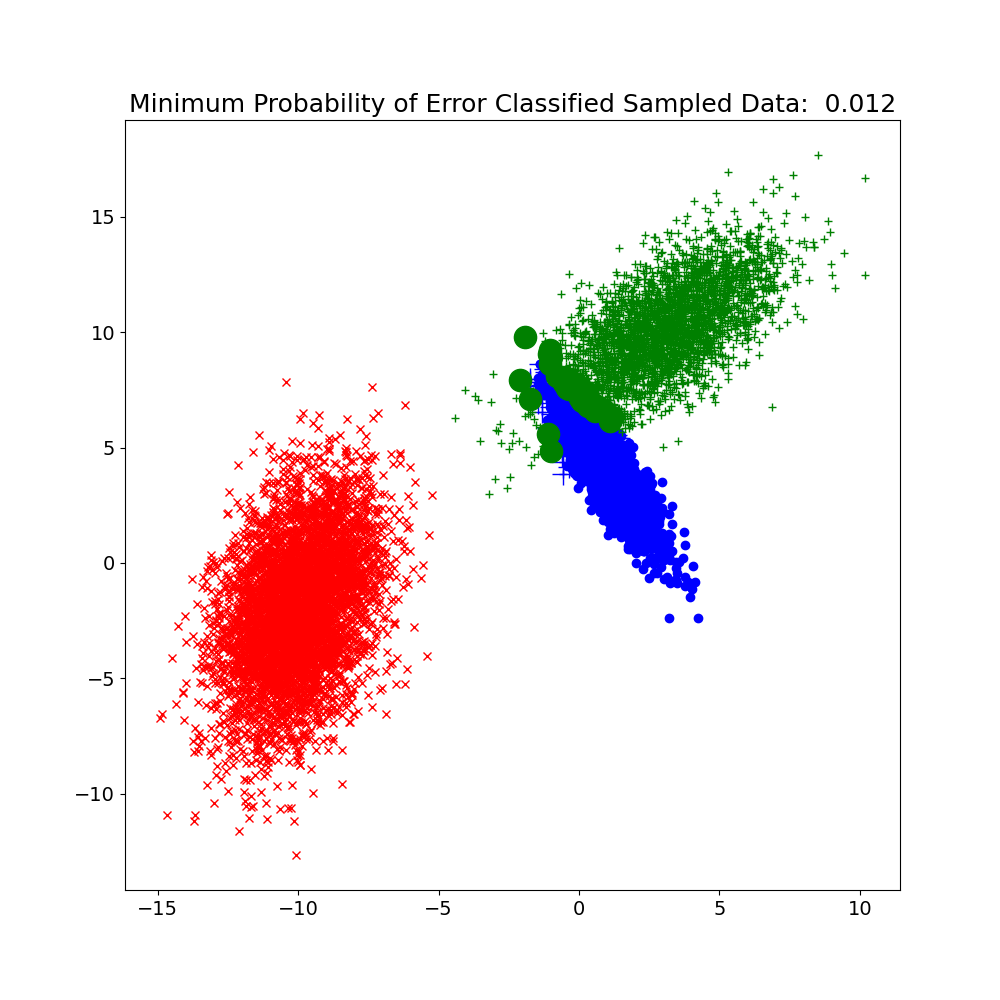

In [8]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = 'ox+*.' # Accomodates up to C=5
marker_colors = 'brgmy'

# Get sample class counts
sample_class_counts = np.array([sum(y == j) for j in Y])

# Confusion matrix
conf_mat = np.zeros((C, C))
for i in Y: # Each decision option
    for j in Y: # Each class label
        ind_ij = np.argwhere((decisions==i) & (y==j))
        conf_mat[i, j] = len(ind_ij)/sample_class_counts[j] # Average over class sample count

        # True label = Marker shape; Decision = Marker Color
        marker = marker_shapes[j] + marker_colors[i]
        plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker)

        if i != j:
            plt.plot(X[ind_ij, 0], X[ind_ij, 1], marker, markersize=16)
            
print("Confusion matrix:")
print(conf_mat)

print("Minimum Probability of Error:")
prob_error = 1 - np.diag(conf_mat).dot(sample_class_counts / N)
print(prob_error)

plt.title("Minimum Probability of Error Classified Sampled Data:  {:.3f}".format(prob_error))
plt.show()